## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import scipy.integrate as integrate
from pathlib import Path

from mpl_toolkits import mplot3d
from scipy.stats import kde as kde_stats

In [2]:
MODEL_DIRECTORY = Path('../../model/')
MAIN_DIRECTORY = Path('../../')

In [3]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [4]:
all_stars = read_file(MODEL_DIRECTORY / 'model_stars_400pc_manystars_power-2.txt')
all_stars = all_stars[(all_stars['bp-rp, mag']>0.1) & (all_stars['bp-rp, mag']<0.4) & 
                      (all_stars['g, mag']<16)] 
isochrone = pd.read_csv(MODEL_DIRECTORY / (f'isochrone_model_8.5.txt'), delimiter='\\s+')


## creating observational isochrone

In [5]:
 # create data
x = all_stars['bp-rp, mag']
y = all_stars['g, mag']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=200
k = kde_stats.gaussian_kde([x,y],bw_method='scott')
k.set_bandwidth(bw_method=k.factor / 3)

xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
f = zi.reshape(xi.shape)

In [6]:
isochrone_f = pd.DataFrame()
for i in range(0, nbins):
    value = f[i,:].max()
    index_y = f[i,:].argmax()
    
    isochrone_f = isochrone_f.append(
                    pd.Series([xi[i,0], yi[0,index_y]]), ignore_index=True)
    

In [7]:
isochrone_f = isochrone_f.rename(columns={0 : 'bp-rp, mag', 1 : 'g, mag'})

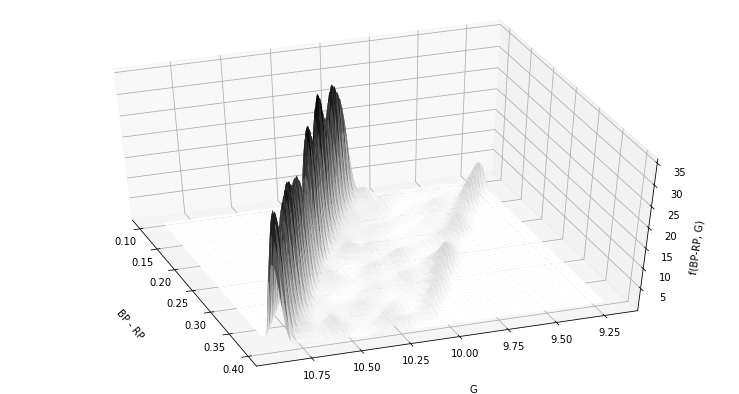

In [8]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xi,yi, f, cmap='binary')
ax.set_xlabel('BP - RP', labelpad=29)
ax.set_ylabel('G', labelpad=29)
ax.set_zlabel('f(BP-RP, G)', labelpad=5)
ax.invert_yaxis()

ax.view_init(45, 340)

In [9]:
isochrone_f['g, mag'] = savgol_filter(isochrone_f['g, mag'],7,2)

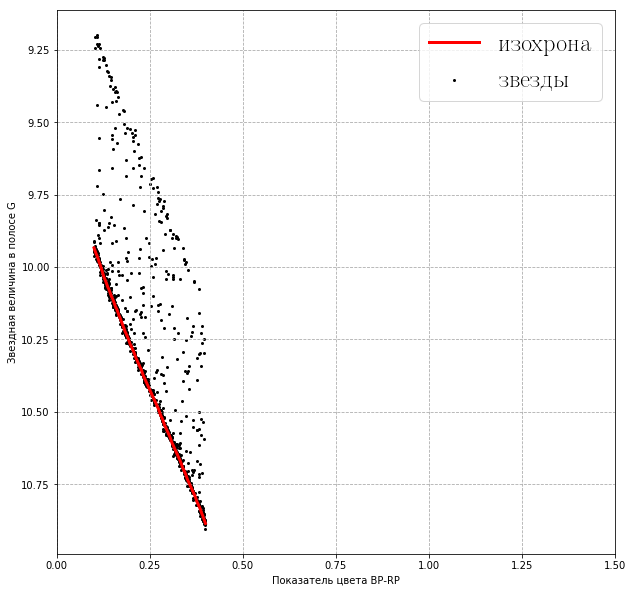

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter (all_stars['bp-rp, mag'] , all_stars['g, mag'] , c ='black', s = 4, label ='звезды')
# ax.plot(isochrone['G_BPmag']-isochrone['G_RPmag'],
#        isochrone['Gmag'] + 5 * np.log10(400) - 5, c ='green', lw = 3, label ='изохрона истинная')
ax.plot(isochrone_f['bp-rp, mag'],isochrone_f['g, mag'] , c ='red', lw=3,  label ='изохрона ')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

ax.set_xlim(0,1.5)

#ax.set_xlim(0.1,0.4)
#ax.set_ylim(8.5,11.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend()
plt.savefig(MODEL_DIRECTORY / 'plots' / "cmd_approximation.pdf", bbox_inches = 'tight')
plt.show()

In [11]:
# isochrone = isochrone[(isochrone['G_BPmag']-isochrone['G_RPmag']>0) & 
#                       (isochrone['G_BPmag']-isochrone['G_RPmag']<1.5)]

# isochrone_compar = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag'])
# isochrone_difference = (isochrone['Gmag'] + 5 * np.log10(400) - 5 - 
#                         isochrone_compar(isochrone['G_BPmag']-isochrone['G_RPmag']))
# abs(isochrone_difference / (isochrone['Gmag'] + 5 * np.log10(400) - 5)).max()
# #sum(isochrone_difference > 0) / len(isochrone_difference)

## transition to the modified magnitude

In [12]:
func_iso = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag']) 
all_stars['Gmag_new'] = all_stars['g, mag'] - func_iso(all_stars['bp-rp, mag'])

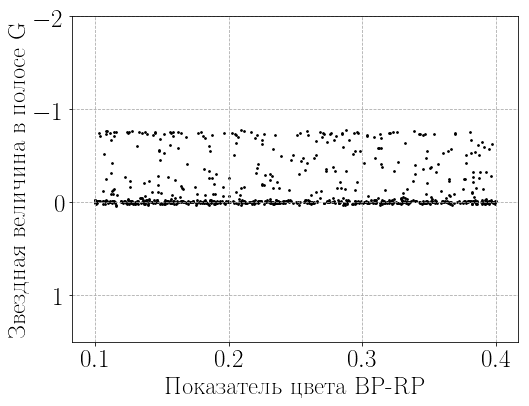

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter (singles_data['bp-rp, mag'] , singles_data['Gmag_new'] , c ='black', s = 3, label ='звезды')
# ax.scatter (binaries_data['bp-rp, mag'] , binaries_data['Gmag_new'] , c ='red', s = 3, label ='звезды')
ax.scatter (all_stars['bp-rp, mag'] , all_stars['Gmag_new'] , c ='black', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2,1.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
#ax.legend(fontsize = 15)
plt.savefig(MODEL_DIRECTORY / 'plots' / "horizontal_sequence.pdf", bbox_inches = 'tight')
plt.show()

## creating density profile

In [14]:
num_stars = len(all_stars)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
x = all_stars['Gmag_new']

# use grid search cross-validation to optimize the bandwidth
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.005, 0.2, 50)}, iid=True, cv=4) 
grid.fit(x[:, None])
bandwidth_opt = sum(grid.best_params_.values())

In [15]:
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_opt)

kde.fit(all_stars[['Gmag_new']].to_numpy())
profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) * num_stars

Text(0.5, 0, '$G_{new}$')

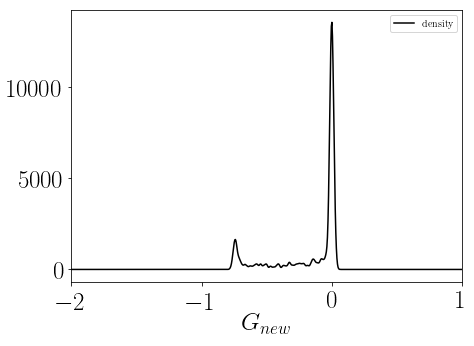

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

In [17]:
def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-15:row_max+155, 0], profile.iloc[row_max-15:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [70000, profile.iloc[row_max, 0]+0.1, 0.8, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

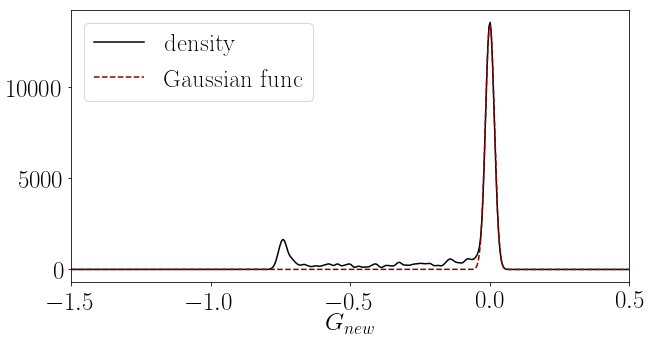

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.5, ls='--', color='darkred', label='Gaussian func')

ax.set_xlim(-1.5, 0.5)

ax.legend(loc='upper left')
ax.set_xlabel('$G_{new}$')
fig.savefig(MODEL_DIRECTORY / 'plots' / f"model_profile_400pc_manystars_power-2.pdf", bbox_inches = 'tight')

In [19]:
profile_difference = pd.DataFrame()
profile_difference['x'], profile_difference['density'] = profile['x'], profile['density'] - profile_gauss['density']

## calculate binaries fraction & other metrics

In [20]:
binaries = all_stars[all_stars['Mass1']>0].copy()

num_stars = len(binaries)
profile_binaries = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_opt)
kde.fit(binaries[['Gmag_new']].to_numpy())

profile_binaries['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile_binaries['density'] *= num_stars

In [21]:
singles = all_stars[all_stars['Mass']>0]

num_stars = len(singles)
profile_singles = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_opt)
kde.fit(singles[['Gmag_new']].to_numpy())

profile_singles['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile_singles['density'] *= num_stars

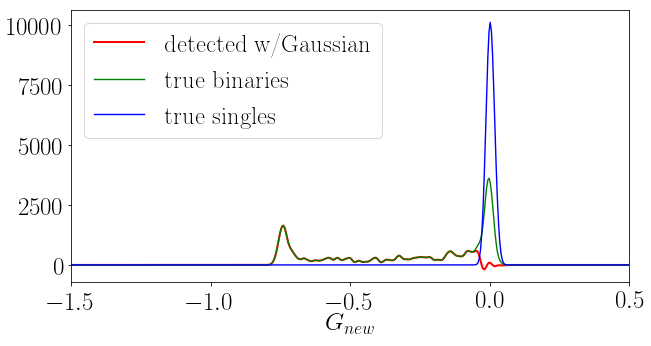

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 2, color = 'red', label='detected w/Gaussian')
      
ax.plot(profile['x'], profile_binaries['density'], lw = 1.4, color = 'green', label='true binaries')
ax.plot(profile['x'], profile_singles['density'], lw = 1.4, color = 'blue', label='true singles')
ax.set_xlim(-1.5, 0.5)

ax.legend(loc='upper left')
ax.set_xlabel('$G_{new}$')
fig.savefig(MODEL_DIRECTORY / 'plots' / f"model_profile_400pc_manystars_power-2_binaries.pdf", bbox_inches = 'tight')

In [23]:
difference_g = profile['density'] - profile_gauss['density']
difference_g[difference_g < 0] = 0

number_of_multiples = int(integrate.simps(difference_g, profile['x']))

In [24]:
len(all_stars[(all_stars['Mass']>0) == False]) / len(all_stars)

0.513681592039801

In [25]:
# доля двойных из интегрирования профиля
number_of_multiples / len(all_stars)

0.3283582089552239

In [26]:
number_of_multiples / len(all_stars[(all_stars['Mass']>0) == False])

0.639225181598063

## q interval research

In [27]:
binaries['q'] = binaries['Mass2'] / binaries['Mass1']

In [28]:
q_array = np.linspace(binaries['q'].min(), 0.5, 100)
comparison = []

In [29]:
for q in q_array:
    profile_part = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})

    binaries_g = binaries[(binaries['q'] > q) == True][['Gmag_new']]
    kde.fit(binaries_g.to_numpy())
    
    profile_part['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
    profile_part['density'] *= len(binaries_g)
    
    comparison.append(sum(profile_part['density'] - profile_difference['density']))

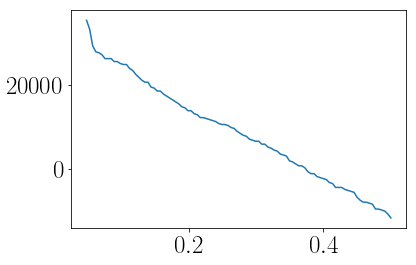

In [30]:
plt.plot(q_array, comparison)

In [31]:
q_array[abs(np.array(comparison)).argmin()]

0.3723927377417203